# Machine Learning for Optical Network Security Monitoring: A Practical Perspective

This file contains the implementation of the training and evaluation of the supervised learning strategy (artificial neural network).
<p style='color: red'>Note that the dataset is not made available due to confidentiality agreements in place.</p>

In the experiments, we evaluate two main settings:
- The ANN architecture, defined as the number of layers and number of neurons at each layer.
- The dataset use, with three different options:
  - Using the full dataset (single dataset for path 1 and path 2) to train a single ANN without specifying which samples comes from which path (we do not have one-hot information for the path).
  - Training the ANN for a single path (two ANNs, one for each path).
  - Using the full dataset to train a single ANN specifying the path which a sample comes from (including two one-hot columns for the path identification).

In the paper, we selected the ANN architecture [50, 100, 50] as the best one, and the full dataset including the one-hot columns identifying the lightpath as the best option.

In [1]:
import numpy as np
from functools import partial
import itertools
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import pandas as pd
import os
import time
import pickle
import logging

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.initializers import glorot_normal
from sklearn.metrics import confusion_matrix
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from IPython import display

figure_format = 'svg'

## Importing dataset

Loading the dataset from the XLSX file, creating some columns and cleaning it using pandas.

<p style='color: red'>Note that the dataset is not made available due to confidentiality agreements in place.</p>

In [2]:
seed = 42
np.random.seed(seed)
number_epochs = 1000
folder = '/nobackup/carda/datasets/ml-simulation-optical/2019-ecoc-demo'
final_dataframe = None
file_names = ['BSL', 'INBMOD', 'INBSTRONG', 'OOBMOD', 'OOBSTRONG', 'POLMODbis', 'POLSTRONG']
class_names = ['BSL', 'INBLGT', 'INBSTR', 'OOBLGT', 'OOBSTR', 'POLLGT', 'POLSTR']
for path_e in [1, 2]:
    for idc, clazz in enumerate(file_names):
        print(path_e, clazz)
        dataframe = pd.read_excel(folder + "/" + clazz + '13' + str(path_e) + '.xlsx', 'risultati', header=[0])
        
        # removing unused features
        dataframe = dataframe.drop(['n', 'time stamp', 'BE-FEC', 'UBE-FEC', 'OFT', 'OFT-max', 'OFT-min'], axis=1)
        
        # creating a one-hot column for the path
        dataframe['path_1'] = 1 if path_e == 1 else 0
        dataframe['path_2'] = 1 if path_e == 2 else 0
        
        dataframe['attack'] = idc
        
        # remove samples with missing data
        dataframe = dataframe[~dataframe.isin([np.nan, np.inf, -np.inf]).any(1)]
        
        # concatenating with the final dataset
        if final_dataframe is None:
            final_dataframe = dataframe
        else:
            final_dataframe = pd.concat([final_dataframe, dataframe], ignore_index=True)

1 BSL
1 INBMOD
1 INBSTRONG
1 OOBMOD
1 OOBSTRONG
1 POLMODbis
1 POLSTRONG
2 BSL
2 INBMOD
2 INBSTRONG
2 OOBMOD
2 OOBSTRONG
2 POLMODbis
2 POLSTRONG


In [3]:
# make sure that attack column is the last one
columns = list(final_dataframe.columns)
columns.remove('attack')
columns.append('attack')
final_dataframe = final_dataframe[columns]
final_dataframe.describe()

,BER-FEC,BER-FEC-max,BER-FEC-min,BER-POST-FEC,BER-POST-FEC-max,BER-POST-FEC-min,LOSS,OPR,OPR-max,OPR-min,...,OSNR-min,PDL,PDL-max,PDL-min,Q-factor,Q-factor-max,Q-factor-min,path_1,path_2,attack
count,19882.000000,19882.000000,19882.000000,19882.000000,19882.000000,19882.000000,19882.0,19882.000000,19882.000000,19882.000000,...,19882.000000,19882.00000,19882.000000,19882.000000,19882.000000,19882.000000,19882.000000,19882.000000,19882.000000,19882.000000
mean,0.012379,0.017101,0.010983,0.001574,0.002586,0.000754,0.0,-10.556373,-10.533733,-10.579093,...,19.448328,0.60849,0.934011,0.462780,7.143919,7.250221,6.895393,0.500151,0.499849,3.001257
std,0.027561,0.067567,0.008499,0.003461,0.005009,0.002118,0.0,0.353269,0.353096,0.353207,...,3.307222,0.68690,1.041501,0.511276,0.787734,0.724563,1.292874,0.500013,0.500013,2.003003
min,0.002885,0.003119,0.002734,0.000000,0.000000,0.000000,0.0,-11.125000,-11.085000,-11.155000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.006552,0.007758,0.005488,0.000000,0.000000,0.000000,0.0,-10.755000,-10.725000,-10.775000,...,19.169900,0.00000,0.000000,0.000000,6.700000,6.800000,6.600000,0.000000,0.000000,1.000000
50%,0.012653,0.013216,0.012376,0.000000,0.000000,0.000000,0.0,-10.635000,-10.615000,-10.655000,...,19.436800,1.00000,1.000000,0.000000,6.900000,7.000000,6.900000,1.000000,0.000000,3.000000
75%,0.014464,0.015115,0.014093,0.000718,0.000981,0.000110,0.0,-10.515000,-10.495000,-10.535000,...,21.212800,1.00000,1.000000,1.000000,7.800000,8.000000,7.600000,1.000000,1.000000,5.000000
max,1.000000,1.000000,1.000000,0.015633,0.015634,0.015301,0.0,-9.485000,-9.455000,-9.495000,...,22.369100,8.00000,8.000000,5.000000,8.800000,8.800000,8.600000,1.000000,1.000000,6.000000


## Helper functions

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          colorbar=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    It uses a figure previously opened, if any.
    After calling, the figure can be modified/finalized.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.nan_to_num(cm) # avoids NaN values

    # plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.pcolor(cm, cmap=cmap, edgecolors='gray')
    if title is not None:
        plt.title(title)
    plt.gca().invert_yaxis()
    if colorbar:
        plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks + 0.5, classes, rotation=30)
    plt.yticks(tick_marks + 0.5, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if cm[i, j] == 0.0:
            text = '-'
        elif cm[i, j] == 1.0:
            text = '1.0'
        else:
            text = format(cm[i, j], fmt)
        plt.text(j + 0.5, i + 0.7, text,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True attack')
    plt.xlabel('Predicted attack')

In [5]:
# define baseline model for classification using neural network
def baseline_model(input_dim, output_dim, layers):
    # create model
    assert len(layers) > 0
    model = Sequential()
    model.add(Dense(layers[0], input_dim=input_dim, activation='linear', kernel_initializer=glorot_normal(seed))) # using linear because dataset is not normalized
    for l in range(1, len(layers)):
        model.add(Dense(layers[l], activation='tanh', kernel_initializer=glorot_normal(seed)))
    # for the neural network it outputs one neuron for each class, that is why a softmax activation
    model.add(Dense(output_dim, activation='softmax', kernel_initializer=glorot_normal(seed)))
    # compile model
    # categorical_crossentropy is the loss used for multi-class classification problems
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
    return model

## Cross-validation for the different settings

In [6]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
scoring = ['accuracy', 'balanced_accuracy']

# set of configurations for the layers in the ANN
layers_to_consider = [
    [50, 100],
    [100, 100],
    [50, 100, 50],
    [100, 100, 100],
    [200, 200, 200],
    [50],
    [50, 50]
]

In [7]:
### using the full dataset (one-hot vector for the path)

results_cv_one_hot = []

raw_dataset = final_dataframe.values
X_raw_dataset = raw_dataset[:, 0:raw_dataset.shape[1] - 1].astype(float)
Y_raw_dataset = raw_dataset[:, raw_dataset.shape[1] - 1].astype(float)

scaler = StandardScaler().fit(X_raw_dataset)
X_raw_transformed = scaler.transform(X_raw_dataset)

for idl, layers in enumerate(layers_to_consider):
    print('test', idl, '\ttraining ANN with layers:', layers)
    results_cv_one_hot.append({})
    call_model = partial(baseline_model, X_raw_dataset.shape[1], 7, layers)
    clf = KerasClassifier(build_fn=call_model, batch_size=200, verbose=0, shuffle=True, epochs=number_epochs)
    start_time = time.time()
    cv_scores = cross_validate(clf, X_raw_transformed, Y_raw_dataset, cv=skf, return_train_score=True, scoring=scoring, verbose=False)
    end_time = time.time()
    results_cv_one_hot[-1]['cross_validation'] = cv_scores
    results_cv_one_hot[-1]['cross_validation_time'] = end_time - start_time
    print("CV training avg. accuracy (%): {:.5f} +/- {:.5f}\tCV testing avg. accuracy (%): {:.5f} +/- {:.5f}\tTraining time (s): {}\n".format(np.mean(cv_scores['train_balanced_accuracy']), 
                                                                                    np.std(cv_scores['train_balanced_accuracy']), 
                                                                                    np.mean(cv_scores['test_balanced_accuracy']), 
                                                                                    np.std(cv_scores['test_balanced_accuracy']), 
                                                                                      np.mean(cv_scores['fit_time'])))

test 0 	training ANN with layers: [50, 100]
CV training avg. accuracy (%): 0.99715 +/- 0.00032	CV testing avg. accuracy (%): 0.98711 +/- 0.00171	Training time (s): 156.83498673439027

test 1 	training ANN with layers: [100, 100]
CV training avg. accuracy (%): 0.99821 +/- 0.00024	CV testing avg. accuracy (%): 0.98731 +/- 0.00191	Training time (s): 156.79331755638123

test 2 	training ANN with layers: [50, 100, 50]
CV training avg. accuracy (%): 0.99906 +/- 0.00036	CV testing avg. accuracy (%): 0.98791 +/- 0.00220	Training time (s): 165.95602371692658

test 3 	training ANN with layers: [100, 100, 100]
CV training avg. accuracy (%): 0.99941 +/- 0.00026	CV testing avg. accuracy (%): 0.98671 +/- 0.00361	Training time (s): 170.7947185754776

test 4 	training ANN with layers: [200, 200, 200]
CV training avg. accuracy (%): 0.99959 +/- 0.00096	CV testing avg. accuracy (%): 0.98741 +/- 0.00231	Training time (s): 172.8446623802185

test 5 	training ANN with layers: [50]
CV training avg. accuracy 

In [8]:
### using the full dataset without specifying the path

results_cv_full_dataset = []

raw_dataset = final_dataframe.drop(['path_1', 'path_2'], axis=1).values
X_raw_dataset = raw_dataset[:, 0:raw_dataset.shape[1] - 1].astype(float)
Y_raw_dataset = raw_dataset[:, raw_dataset.shape[1] - 1].astype(float)

scaler = StandardScaler().fit(X_raw_dataset)
X_raw_transformed = scaler.transform(X_raw_dataset)

for idl, layers in enumerate(layers_to_consider):
    print('test', idl, '\ttraining ANN with layers:', layers)
    results_cv_full_dataset.append({})
    call_model = partial(baseline_model, X_raw_dataset.shape[1], 7, layers)
    clf = KerasClassifier(build_fn=call_model, batch_size=200, verbose=0, shuffle=True, epochs=number_epochs)
    start_time = time.time()
    cv_scores = cross_validate(clf, X_raw_transformed, Y_raw_dataset, cv=skf, return_train_score=True, scoring=scoring, verbose=False)
    end_time = time.time()
    results_cv_full_dataset[-1]['cross_validation'] = cv_scores
    results_cv_full_dataset[-1]['cross_validation_time'] = end_time - start_time
    print("CV training avg. accuracy (%): {:.5f} +/- {:.5f}\tCV testing avg. accuracy (%): {:.5f} +/- {:.5f}\tTraining time (s): {}\n".format(np.mean(cv_scores['train_balanced_accuracy']), 
                                                                                    np.std(cv_scores['train_balanced_accuracy']), 
                                                                                    np.mean(cv_scores['test_balanced_accuracy']), 
                                                                                    np.std(cv_scores['test_balanced_accuracy']), 
                                                                                      np.mean(cv_scores['fit_time'])))

test 0 	training ANN with layers: [50, 100]
CV training avg. accuracy (%): 0.99707 +/- 0.00023	CV testing avg. accuracy (%): 0.98640 +/- 0.00293	Training time (s): 160.4213490486145

test 1 	training ANN with layers: [100, 100]
CV training avg. accuracy (%): 0.99822 +/- 0.00022	CV testing avg. accuracy (%): 0.98656 +/- 0.00183	Training time (s): 163.3053340435028

test 2 	training ANN with layers: [50, 100, 50]
CV training avg. accuracy (%): 0.99902 +/- 0.00026	CV testing avg. accuracy (%): 0.98701 +/- 0.00200	Training time (s): 165.975829744339

test 3 	training ANN with layers: [100, 100, 100]
CV training avg. accuracy (%): 0.99944 +/- 0.00023	CV testing avg. accuracy (%): 0.98616 +/- 0.00245	Training time (s): 172.09316623210907

test 4 	training ANN with layers: [200, 200, 200]
CV training avg. accuracy (%): 0.99982 +/- 0.00023	CV testing avg. accuracy (%): 0.98756 +/- 0.00224	Training time (s): 164.81809470653533

test 5 	training ANN with layers: [50]
CV training avg. accuracy (%

In [9]:
### using the full dataset with only path 1

results_cv_path_1 = []

raw_dataset = final_dataframe[(final_dataframe['path_1'] == 1)].drop(['path_1', 'path_2'], axis=1).values
X_raw_dataset = raw_dataset[:, 0:raw_dataset.shape[1] - 1].astype(float)
Y_raw_dataset = raw_dataset[:, raw_dataset.shape[1] - 1].astype(float)

scaler = StandardScaler().fit(X_raw_dataset)
X_raw_transformed = scaler.transform(X_raw_dataset)

for idl, layers in enumerate(layers_to_consider):
    print('test', idl, '\ttraining ANN with layers:', layers)
    results_cv_path_1.append({})
    call_model = partial(baseline_model, X_raw_dataset.shape[1], 7, layers)
    clf = KerasClassifier(build_fn=call_model, batch_size=200, verbose=0, shuffle=True, epochs=number_epochs)
    start_time = time.time()
    cv_scores = cross_validate(clf, X_raw_transformed, Y_raw_dataset, cv=skf, return_train_score=True, scoring=scoring, verbose=False)
    end_time = time.time()
    results_cv_path_1[-1]['cross_validation'] = cv_scores
    results_cv_path_1[-1]['cross_validation_time'] = end_time - start_time
    print("CV training avg. accuracy (%): {:.5f} +/- {:.5f}\tCV testing avg. accuracy (%): {:.5f} +/- {:.5f}\tTraining time (s): {}\n".format(np.mean(cv_scores['train_balanced_accuracy']), 
                                                                                    np.std(cv_scores['train_balanced_accuracy']), 
                                                                                    np.mean(cv_scores['test_balanced_accuracy']), 
                                                                                    np.std(cv_scores['test_balanced_accuracy']), 
                                                                                      np.mean(cv_scores['fit_time'])))

test 0 	training ANN with layers: [50, 100]
CV training avg. accuracy (%): 0.99478 +/- 0.00041	CV testing avg. accuracy (%): 0.98448 +/- 0.00341	Training time (s): 85.42426586151123

test 1 	training ANN with layers: [100, 100]
CV training avg. accuracy (%): 0.99693 +/- 0.00033	CV testing avg. accuracy (%): 0.98318 +/- 0.00355	Training time (s): 84.01830174922944

test 2 	training ANN with layers: [50, 100, 50]
CV training avg. accuracy (%): 0.99822 +/- 0.00039	CV testing avg. accuracy (%): 0.98587 +/- 0.00205	Training time (s): 88.05975227355957

test 3 	training ANN with layers: [100, 100, 100]
CV training avg. accuracy (%): 0.99880 +/- 0.00044	CV testing avg. accuracy (%): 0.98458 +/- 0.00271	Training time (s): 93.78456506729125

test 4 	training ANN with layers: [200, 200, 200]
CV training avg. accuracy (%): 0.99970 +/- 0.00026	CV testing avg. accuracy (%): 0.98408 +/- 0.00240	Training time (s): 93.4284722328186

test 5 	training ANN with layers: [50]
CV training avg. accuracy (%):

In [10]:
### using the full dataset with only path 2

results_cv_path_2 = []

raw_dataset = final_dataframe[(final_dataframe['path_2'] == 1)].drop(['path_1', 'path_2'], axis=1).values
X_raw_dataset = raw_dataset[:, 0:raw_dataset.shape[1] - 1].astype(float)
Y_raw_dataset = raw_dataset[:, raw_dataset.shape[1] - 1].astype(float)

scaler = StandardScaler().fit(X_raw_dataset)
X_raw_transformed = scaler.transform(X_raw_dataset)

for idl, layers in enumerate(layers_to_consider):
    print('test', idl, '\ttraining ANN with layers:', layers)
    results_cv_path_2.append({})
    call_model = partial(baseline_model, X_raw_dataset.shape[1], 7, layers)
    clf = KerasClassifier(build_fn=call_model, batch_size=200, verbose=0, shuffle=True, epochs=number_epochs)
    start_time = time.time()
    cv_scores = cross_validate(clf, X_raw_transformed, Y_raw_dataset, cv=skf, return_train_score=True, scoring=scoring, verbose=False)
    end_time = time.time()
    results_cv_path_2[-1]['cross_validation'] = cv_scores
    results_cv_path_2[-1]['cross_validation_time'] = end_time - start_time
    print("CV training avg. accuracy (%): {:.5f} +/- {:.5f}\tCV testing avg. accuracy (%): {:.5f} +/- {:.5f}\tTraining time (s): {}\n".format(np.mean(cv_scores['train_balanced_accuracy']), 
                                                                                    np.std(cv_scores['train_balanced_accuracy']), 
                                                                                    np.mean(cv_scores['test_balanced_accuracy']), 
                                                                                    np.std(cv_scores['test_balanced_accuracy']), 
                                                                                      np.mean(cv_scores['fit_time'])))

test 0 	training ANN with layers: [50, 100]
CV training avg. accuracy (%): 0.99929 +/- 0.00017	CV testing avg. accuracy (%): 0.98720 +/- 0.00425	Training time (s): 77.49295806884766

test 1 	training ANN with layers: [100, 100]
CV training avg. accuracy (%): 0.99998 +/- 0.00004	CV testing avg. accuracy (%): 0.98609 +/- 0.00356	Training time (s): 85.69375426769257

test 2 	training ANN with layers: [50, 100, 50]
CV training avg. accuracy (%): 1.00000 +/- 0.00000	CV testing avg. accuracy (%): 0.98639 +/- 0.00417	Training time (s): 89.09290022850037

test 3 	training ANN with layers: [100, 100, 100]
CV training avg. accuracy (%): 1.00000 +/- 0.00000	CV testing avg. accuracy (%): 0.98387 +/- 0.00597	Training time (s): 91.95431954860688

test 4 	training ANN with layers: [200, 200, 200]
CV training avg. accuracy (%): 1.00000 +/- 0.00000	CV testing avg. accuracy (%): 0.98649 +/- 0.00443	Training time (s): 89.32810702323914

test 5 	training ANN with layers: [50]
CV training avg. accuracy (%)

In [11]:
# saving the results to a binary file
with open('./models/cross_validation_results.h5', 'wb') as f:
    pickle.dump({
        'layers_to_consider': layers_to_consider,
        'results_cv_one_hot': results_cv_one_hot,
        'results_cv_full_dataset': results_cv_full_dataset,
        'results_cv_path_1': results_cv_path_1,
        'results_cv_path_2': results_cv_path_2
    }, f)

In [25]:
# generating a table with the cross-validation test score
print('Cross-validation test score')
print('ANN. Arch.'.ljust(15),'\t', 'OH'.ljust(15), '\t', 'FD'.ljust(15), '\t', 'P1'.ljust(15), '\t', 'P2'.ljust(15))
highest_acc = .0
highest_acc_arch = None
for idx, x in enumerate(layers_to_consider):
    print(str(x).ljust(15), '\t', 
          '{:.4f} +- {:.4f}'.format(
              np.mean(results_cv_one_hot[idx]['cross_validation']['test_balanced_accuracy']),
              np.std(results_cv_one_hot[idx]['cross_validation']['test_balanced_accuracy'])),
          ' \t {:.4f} +- {:.4f}'.format(
              np.mean(results_cv_full_dataset[idx]['cross_validation']['test_balanced_accuracy']),
              np.std(results_cv_full_dataset[idx]['cross_validation']['test_balanced_accuracy'])),
          ' \t {:.4f} +- {:.4f}'.format(
              np.mean(results_cv_path_1[idx]['cross_validation']['test_balanced_accuracy']),
              np.std(results_cv_path_1[idx]['cross_validation']['test_balanced_accuracy'])),
          ' \t {:.4f} +- {:.4f}'.format(
              np.mean(results_cv_path_2[idx]['cross_validation']['test_balanced_accuracy']),
              np.std(results_cv_path_2[idx]['cross_validation']['test_balanced_accuracy']))
         )

ANN. Arch.      	 OH              	 FD              	 P1              	 P2             
[50, 100]       	 0.9871 +- 0.0017  	 0.9864 +- 0.0029  	 0.9845 +- 0.0034  	 0.9872 +- 0.0042
[100, 100]      	 0.9873 +- 0.0019  	 0.9866 +- 0.0018  	 0.9832 +- 0.0036  	 0.9861 +- 0.0036
[50, 100, 50]   	 0.9879 +- 0.0022  	 0.9870 +- 0.0020  	 0.9859 +- 0.0020  	 0.9864 +- 0.0042
[100, 100, 100] 	 0.9867 +- 0.0036  	 0.9862 +- 0.0025  	 0.9846 +- 0.0027  	 0.9839 +- 0.0060
[200, 200, 200] 	 0.9874 +- 0.0023  	 0.9876 +- 0.0022  	 0.9841 +- 0.0024  	 0.9865 +- 0.0044
[50]            	 0.9059 +- 0.0054  	 0.9058 +- 0.0046  	 0.9138 +- 0.0104  	 0.9629 +- 0.0050
[50, 50]        	 0.9866 +- 0.0026  	 0.9854 +- 0.0025  	 0.9796 +- 0.0039  	 0.9869 +- 0.0039


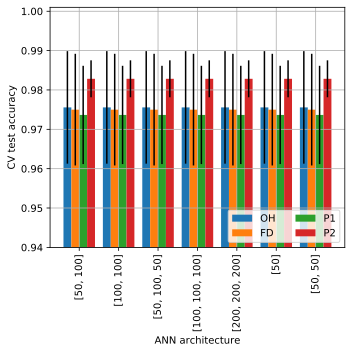

In [14]:
plt.figure(figsize=(5, 5))

plt.bar([x - .3 for x in range(len(results_cv_one_hot))], 
        np.mean([results_cv_one_hot[x]['cross_validation']['test_balanced_accuracy'] for x in range(len(results_cv_one_hot))]), 
        yerr=np.std([results_cv_one_hot[x]['cross_validation']['test_balanced_accuracy'] for x in range(len(results_cv_one_hot))])/2,
        width=.2,
        label='OH')
plt.bar([x - .1 for x in range(len(results_cv_full_dataset))], 
        np.mean([results_cv_full_dataset[x]['cross_validation']['test_balanced_accuracy'] for x in range(len(results_cv_full_dataset))]), 
        yerr=np.std([results_cv_full_dataset[x]['cross_validation']['test_balanced_accuracy'] for x in range(len(results_cv_full_dataset))])/2, 
        width=.2,
        label='FD')
plt.bar([x + .1 for x in range(len(results_cv_path_1))], 
        np.mean([results_cv_path_1[x]['cross_validation']['test_balanced_accuracy'] for x in range(len(results_cv_path_1))]), 
        yerr=np.std([results_cv_path_1[x]['cross_validation']['test_balanced_accuracy'] for x in range(len(results_cv_path_1))])/2, 
        width=.2,
        label='P1')
plt.bar([x + .3 for x in range(len(results_cv_path_1))], 
        np.mean([results_cv_path_2[x]['cross_validation']['test_balanced_accuracy'] for x in range(len(results_cv_path_2))]), 
        yerr=np.std([results_cv_path_2[x]['cross_validation']['test_balanced_accuracy'] for x in range(len(results_cv_path_2))])/2, 
        width=.2,
        label='P2')

plt.xlabel('ANN architecture')
plt.xticks(range(len(results_cv_path_1)), [x for x in layers_to_consider], rotation=90)
plt.ylabel('CV test accuracy')
plt.ylim([0.94, 1.001])
# plt.ylim([0.97, .98])
plt.grid(True)

plt.legend(ncol=2, loc=4)
plt.tight_layout()
plt.savefig(f'./figures/ann_cv_test_accuracy.{figure_format}')
plt.show()

## Generating final results with the selected ANN architecture (50, 100, 50)

### training for the entire dataset with one-hot code for lightpaths

In [30]:
layers = [50, 100, 50]

raw_dataset = final_dataframe.values
X_raw_dataset = raw_dataset[:, 0:raw_dataset.shape[1] - 1].astype(float)
Y_raw_dataset = raw_dataset[:, raw_dataset.shape[1] - 1].astype(float)
scaler = StandardScaler().fit(X_raw_dataset)
X_raw_dataset = scaler.transform(X_raw_dataset)

# X_train = attack_train_X[0]
# Y_train = attack_train_Y[0]
# X_validation = attack_validation_X[0]
# Y_validation = attack_validation_Y[0]
# X_test = attack_test_X[0]
# Y_test = attack_test_Y[0]

X_train, temp_X, Y_train, temp_Y = train_test_split(X_raw_dataset, Y_raw_dataset, random_state=seed, train_size=.5, stratify=Y_raw_dataset)

X_test, X_validation, Y_test, Y_validation = train_test_split(temp_X, temp_Y, random_state=seed, train_size=.5, stratify=temp_Y)

del temp_X, temp_Y # cleaning the memory

Y_train_encoded = tf.keras.utils.to_categorical(Y_train)
Y_test_encoded = tf.keras.utils.to_categorical(Y_test)
Y_validation_encoded = tf.keras.utils.to_categorical(Y_validation)

In [31]:
call_model = partial(baseline_model, X_train.shape[1], 7, layers)

clf = KerasClassifier(build_fn=call_model, batch_size=200, verbose=0, shuffle=True)
start_time = time.time()

output_oh = clf.fit(X_train, Y_train_encoded, validation_data=(X_validation, Y_validation_encoded), epochs=number_epochs, verbose=1)

clf.model.save('models/ann_oh.h5')

Train on 9941 samples, validate on 4971 samples
Epoch 1/1000
9941/9941 [==============================] - 0s 48us/sample - loss: 1.8382 - accuracy: 0.2826 - val_loss: 1.6600 - val_accuracy: 0.4359
Epoch 2/1000
9941/9941 [==============================] - 0s 17us/sample - loss: 1.5327 - accuracy: 0.5237 - val_loss: 1.4211 - val_accuracy: 0.5876
Epoch 3/1000
9941/9941 [==============================] - 0s 17us/sample - loss: 1.3320 - accuracy: 0.6181 - val_loss: 1.2563 - val_accuracy: 0.6381
Epoch 4/1000
9941/9941 [==============================] - 0s 17us/sample - loss: 1.1915 - accuracy: 0.6649 - val_loss: 1.1383 - val_accuracy: 0.6775
Epoch 5/1000
9941/9941 [==============================] - 0s 17us/sample - loss: 1.0866 - accuracy: 0.6996 - val_loss: 1.0467 - val_accuracy: 0.7125
Epoch 6/1000
9941/9941 [==============================] - 0s 24us/sample - loss: 1.0040 - accuracy: 0.7316 - val_loss: 0.9725 - val_accuracy: 0.7355
Epoch 7/1000
9941/9941 [==============================] - 

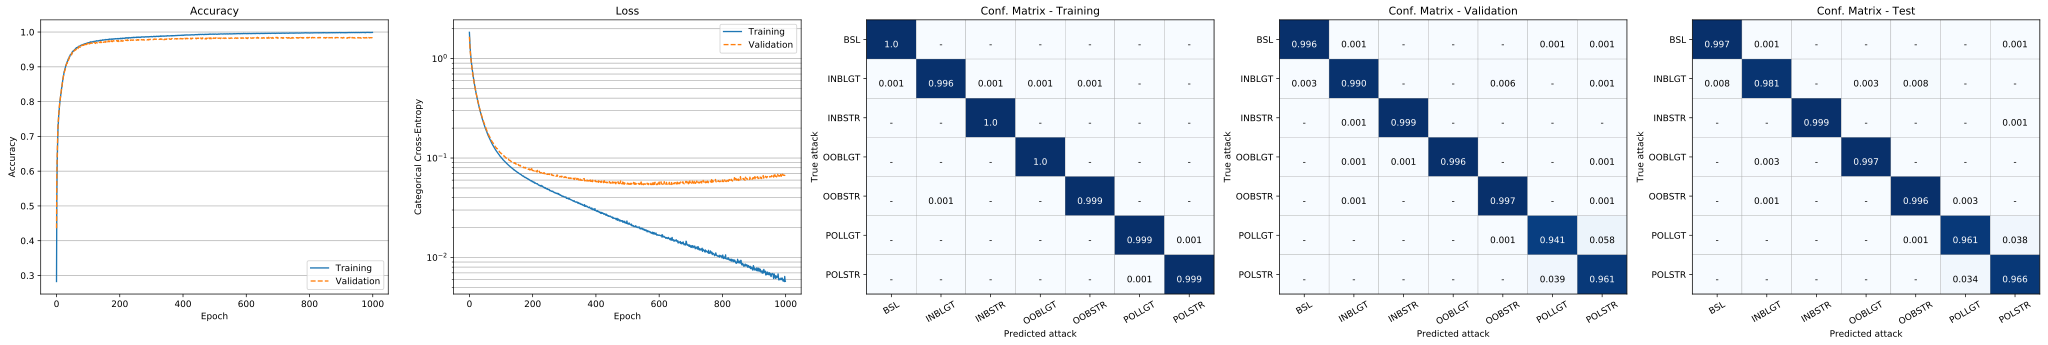

In [36]:
plt.figure(figsize=(32, 5.5))
plt.subplot(1, 5, 1)
plt.plot(output_oh.history['accuracy'], markevery=100)
plt.plot(output_oh.history['val_accuracy'], markevery=100, ls='--')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid(True, which='both', axis='y')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 5, 2)
plt.semilogy(output_oh.history['loss'], markevery=100)
plt.semilogy(output_oh.history['val_loss'], markevery=100, ls='--')
plt.ylabel('Categorical Cross-Entropy')
plt.xlabel('Epoch')
plt.grid(True, which='both', axis='y')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.title('Loss')
        
y_pred = clf.predict(X_train)
cnf_matrix_train_oh = confusion_matrix(y_pred, Y_train)
plt.subplot(1, 5, 3)
plot_confusion_matrix(cnf_matrix_train_oh, classes=class_names, normalize=True,
                                      title='Conf. Matrix - Training')
plt.xlim([0, len(class_names)])
plt.ylim([len(class_names), 0])
        
y_pred = clf.predict(X_validation)
cnf_matrix_validation_oh = confusion_matrix(y_pred, Y_validation)
plt.subplot(1, 5, 4)
plot_confusion_matrix(cnf_matrix_validation_oh, classes=class_names, normalize=True,
                                      title='Conf. Matrix - Validation')
plt.xlim([0, len(class_names)])
plt.ylim([len(class_names), 0])
        
y_pred = clf.predict(X_test)
cnf_matrix_test_oh = confusion_matrix(y_pred, Y_test)
plt.subplot(1, 5, 5)
plot_confusion_matrix(cnf_matrix_test_oh, classes=class_names, normalize=True,
                                      title='Conf. Matrix - Test')
plt.xlim([0, len(class_names)])
plt.ylim([len(class_names), 0])
        
end_time = time.time()

plt.tight_layout()
plt.savefig(f'./figures/training_ann_oh.{figure_format}')
plt.show()
plt.close()

### training for the entire dataset without one-hot code for lightpaths

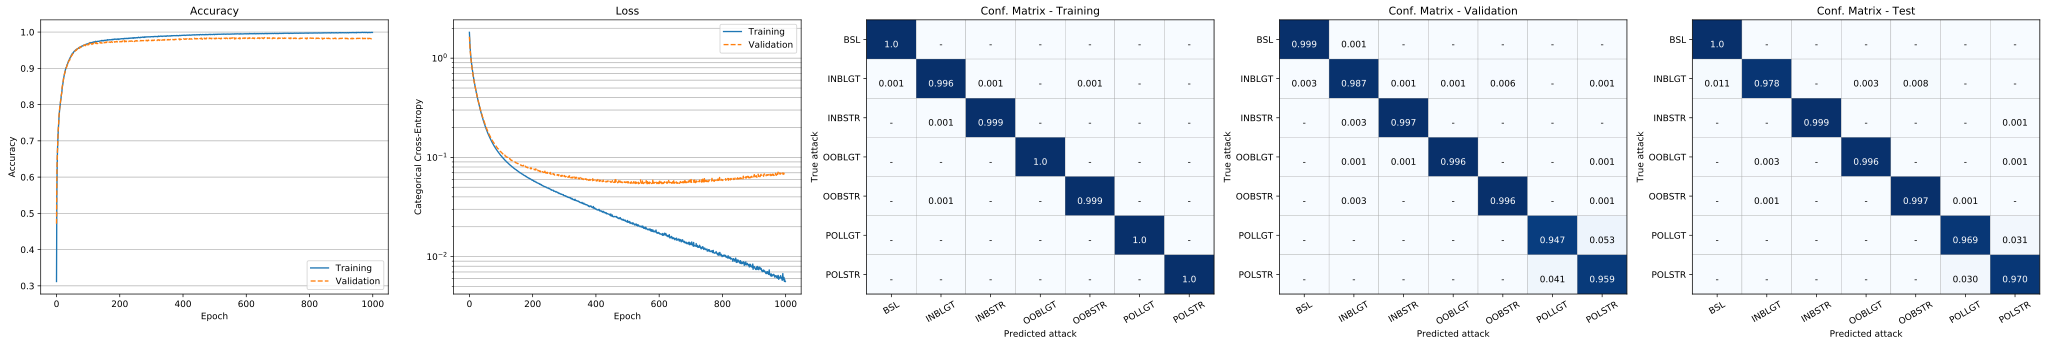

In [40]:
layers = [50, 100, 50]

raw_dataset = final_dataframe.drop(['path_1', 'path_2'], axis=1).values
X_raw_dataset = raw_dataset[:, 0:raw_dataset.shape[1] - 1].astype(float)
Y_raw_dataset = raw_dataset[:, raw_dataset.shape[1] - 1].astype(float)
scaler = StandardScaler().fit(X_raw_dataset)
X_raw_dataset = scaler.transform(X_raw_dataset)

# X_train = attack_train_X[0]
# Y_train = attack_train_Y[0]
# X_validation = attack_validation_X[0]
# Y_validation = attack_validation_Y[0]
# X_test = attack_test_X[0]
# Y_test = attack_test_Y[0]

X_train, temp_X, Y_train, temp_Y = train_test_split(X_raw_dataset, Y_raw_dataset, random_state=seed, train_size=.5, stratify=Y_raw_dataset)

X_test, X_validation, Y_test, Y_validation = train_test_split(temp_X, temp_Y, random_state=seed, train_size=.5, stratify=temp_Y)

del temp_X, temp_Y

Y_train_encoded = tf.keras.utils.to_categorical(Y_train)
Y_test_encoded = tf.keras.utils.to_categorical(Y_test)
Y_validation_encoded = tf.keras.utils.to_categorical(Y_validation)

call_model = partial(baseline_model, X_train.shape[1], 7, layers)

clf = KerasClassifier(build_fn=call_model, batch_size=200, verbose=0, shuffle=True)
start_time = time.time()

output_fd = clf.fit(X_train, Y_train_encoded, validation_data=(X_validation, Y_validation_encoded), epochs=number_epochs, verbose=0)
clf.model.save('models/ann_fd.h5')

plt.figure(figsize=(32, 5.5))
plt.subplot(1, 5, 1)
plt.plot(output_fd.history['accuracy'], markevery=100)
plt.plot(output_fd.history['val_accuracy'], markevery=100, ls='--')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid(True, which='both', axis='y')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 5, 2)
plt.semilogy(output_fd.history['loss'], markevery=100)
plt.semilogy(output_fd.history['val_loss'], markevery=100, ls='--')
plt.ylabel('Categorical Cross-Entropy')
plt.xlabel('Epoch')
plt.grid(True, which='both', axis='y')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.title('Loss')
        
y_pred = clf.predict(X_train)
cnf_matrix_train_fd = confusion_matrix(y_pred, Y_train)
plt.subplot(1, 5, 3)
plot_confusion_matrix(cnf_matrix_train_fd, classes=class_names, normalize=True,
                                      title='Conf. Matrix - Training')
plt.xlim([0, len(class_names)])
plt.ylim([len(class_names), 0])
        
y_pred = clf.predict(X_validation)
cnf_matrix_validation_fd = confusion_matrix(y_pred, Y_validation)
plt.subplot(1, 5, 4)
plot_confusion_matrix(cnf_matrix_validation_fd, classes=class_names, normalize=True,
                                      title='Conf. Matrix - Validation')
plt.xlim([0, len(class_names)])
plt.ylim([len(class_names), 0])
        
y_pred = clf.predict(X_test)
cnf_matrix_test_fd = confusion_matrix(y_pred, Y_test)
plt.subplot(1, 5, 5)
plot_confusion_matrix(cnf_matrix_test_fd, classes=class_names, normalize=True,
                                      title='Conf. Matrix - Test')
plt.xlim([0, len(class_names)])
plt.ylim([len(class_names), 0])
        
end_time = time.time()
#     clf.model.save('models/ann.h5')

plt.tight_layout()
plt.savefig(f'./figures/training_ann_fd.{figure_format}')
plt.show()
plt.close()

### training the ANN only for path 1

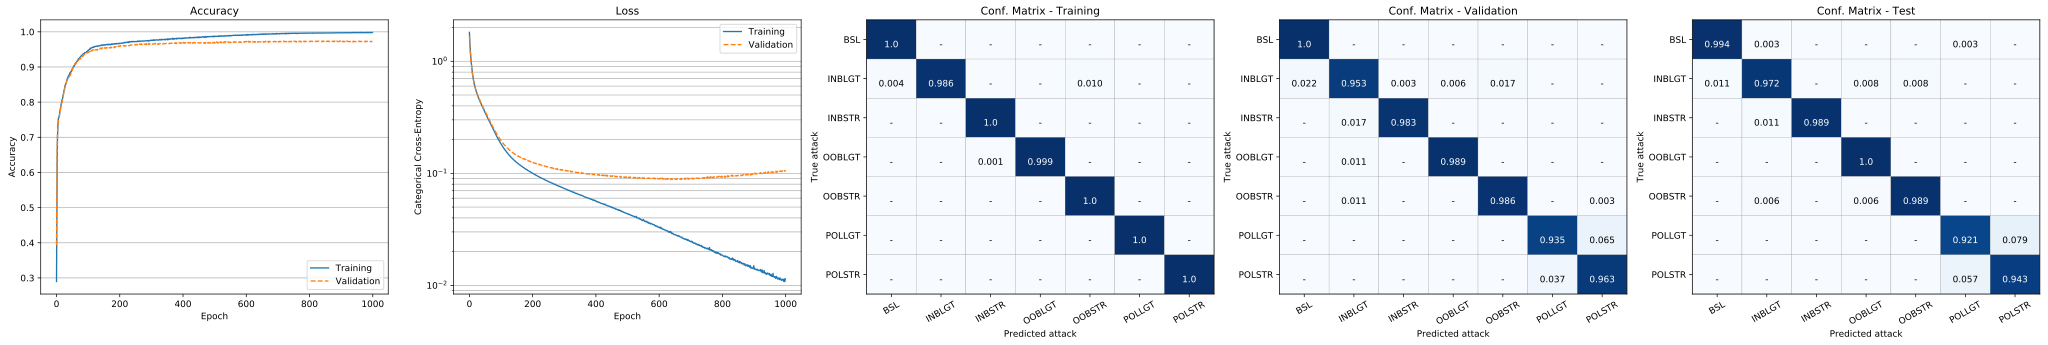

In [42]:
layers = [50, 100, 50]

raw_dataset = final_dataframe[(final_dataframe['path_1'] == 1)].drop(['path_1', 'path_2'], axis=1).values
X_raw_dataset = raw_dataset[:, 0:raw_dataset.shape[1] - 1].astype(float)
Y_raw_dataset = raw_dataset[:, raw_dataset.shape[1] - 1].astype(float)
scaler = StandardScaler().fit(X_raw_dataset)
X_raw_dataset = scaler.transform(X_raw_dataset)

# X_train = attack_train_X[0]
# Y_train = attack_train_Y[0]
# X_validation = attack_validation_X[0]
# Y_validation = attack_validation_Y[0]
# X_test = attack_test_X[0]
# Y_test = attack_test_Y[0]

X_train, temp_X, Y_train, temp_Y = train_test_split(X_raw_dataset, Y_raw_dataset, random_state=seed, train_size=.5, stratify=Y_raw_dataset)

X_test, X_validation, Y_test, Y_validation = train_test_split(temp_X, temp_Y, random_state=seed, train_size=.5, stratify=temp_Y)

del temp_X, temp_Y

Y_train_encoded = tf.keras.utils.to_categorical(Y_train)
Y_test_encoded = tf.keras.utils.to_categorical(Y_test)
Y_validation_encoded = tf.keras.utils.to_categorical(Y_validation)

call_model = partial(baseline_model, X_train.shape[1], 7, layers)

clf = KerasClassifier(build_fn=call_model, batch_size=200, verbose=0, shuffle=True)
start_time = time.time()

output_p1 = clf.fit(X_train, Y_train_encoded, validation_data=(X_validation, Y_validation_encoded), epochs=number_epochs, verbose=0)
clf.model.save('models/ann_p1.h5')

plt.figure(figsize=(32, 5.5))
plt.subplot(1, 5, 1)
plt.plot(output_p1.history['accuracy'], markevery=100)
plt.plot(output_p1.history['val_accuracy'], markevery=100, ls='--')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid(True, which='both', axis='y')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 5, 2)
plt.semilogy(output_p1.history['loss'], markevery=100)
plt.semilogy(output_p1.history['val_loss'], markevery=100, ls='--')
plt.ylabel('Categorical Cross-Entropy')
plt.xlabel('Epoch')
plt.grid(True, which='both', axis='y')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.title('Loss')
        
y_pred = clf.predict(X_train)
cnf_matrix_train_p1 = confusion_matrix(y_pred, Y_train)
plt.subplot(1, 5, 3)
plot_confusion_matrix(cnf_matrix_train_p1, classes=class_names, normalize=True,
                                      title='Conf. Matrix - Training')
plt.xlim([0, len(class_names)])
plt.ylim([len(class_names), 0])
        
y_pred = clf.predict(X_validation)
cnf_matrix_validation_p1 = confusion_matrix(y_pred, Y_validation)
plt.subplot(1, 5, 4)
plot_confusion_matrix(cnf_matrix_validation_p1, classes=class_names, normalize=True,
                                      title='Conf. Matrix - Validation')
plt.xlim([0, len(class_names)])
plt.ylim([len(class_names), 0])
        
y_pred = clf.predict(X_test)
cnf_matrix_test_p1 = confusion_matrix(y_pred, Y_test)
plt.subplot(1, 5, 5)
plot_confusion_matrix(cnf_matrix_test_p1, classes=class_names, normalize=True,
                                      title='Conf. Matrix - Test')
plt.xlim([0, len(class_names)])
plt.ylim([len(class_names), 0])
        
end_time = time.time()
#     clf.model.save('models/ann.h5')

plt.tight_layout()
plt.savefig(f'./figures/training_ann_p1.{figure_format}')
plt.show()
plt.close()

### training the ANN only for path 2

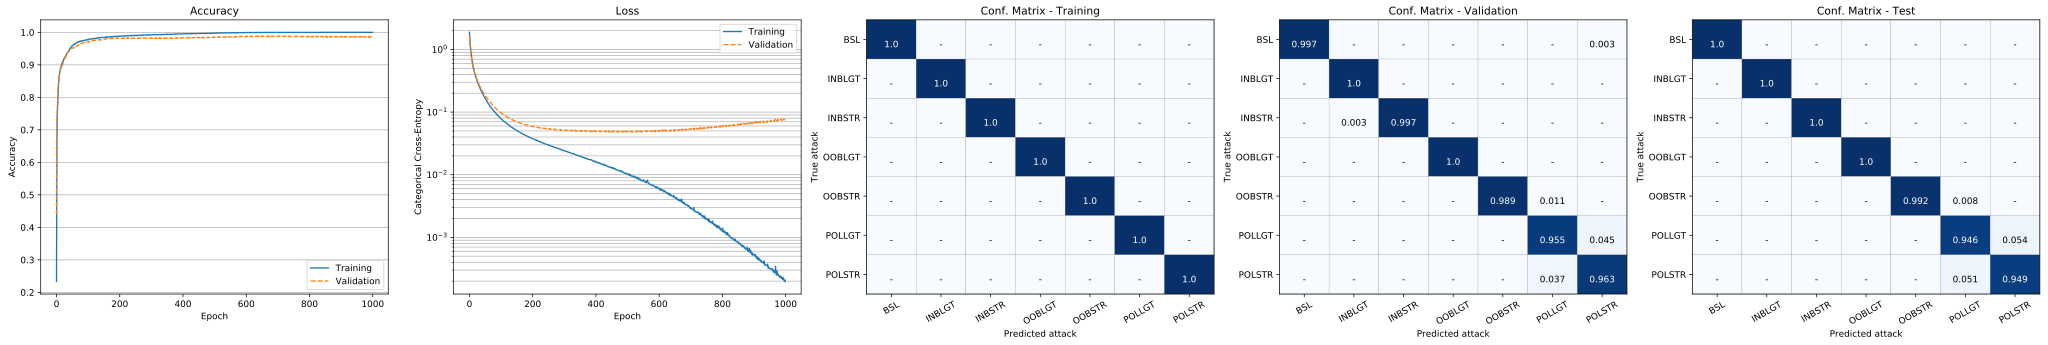

In [43]:
layers = [50, 100, 50]

raw_dataset = final_dataframe[(final_dataframe['path_2'] == 1)].drop(['path_1', 'path_2'], axis=1).values
X_raw_dataset = raw_dataset[:, 0:raw_dataset.shape[1] - 1].astype(float)
Y_raw_dataset = raw_dataset[:, raw_dataset.shape[1] - 1].astype(float)
scaler = StandardScaler().fit(X_raw_dataset)
X_raw_dataset = scaler.transform(X_raw_dataset)

# X_train = attack_train_X[0]
# Y_train = attack_train_Y[0]
# X_validation = attack_validation_X[0]
# Y_validation = attack_validation_Y[0]
# X_test = attack_test_X[0]
# Y_test = attack_test_Y[0]

X_train, temp_X, Y_train, temp_Y = train_test_split(X_raw_dataset, Y_raw_dataset, random_state=seed, train_size=.5, stratify=Y_raw_dataset)

X_test, X_validation, Y_test, Y_validation = train_test_split(temp_X, temp_Y, random_state=seed, train_size=.5, stratify=temp_Y)

del temp_X, temp_Y

Y_train_encoded = tf.keras.utils.to_categorical(Y_train)
Y_test_encoded = tf.keras.utils.to_categorical(Y_test)
Y_validation_encoded = tf.keras.utils.to_categorical(Y_validation)

call_model = partial(baseline_model, X_train.shape[1], 7, layers)

clf = KerasClassifier(build_fn=call_model, batch_size=200, verbose=0, shuffle=True)
start_time = time.time()

output_p2 = clf.fit(X_train, Y_train_encoded, validation_data=(X_validation, Y_validation_encoded), epochs=number_epochs, verbose=0)
clf.model.save('models/ann_p2.h5')

plt.figure(figsize=(32, 5.5))
plt.subplot(1, 5, 1)
plt.plot(output_p2.history['accuracy'], markevery=100)
plt.plot(output_p2.history['val_accuracy'], markevery=100, ls='--')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.grid(True, which='both', axis='y')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.title('Accuracy')

plt.subplot(1, 5, 2)
plt.semilogy(output_p2.history['loss'], markevery=100)
plt.semilogy(output_p2.history['val_loss'], markevery=100, ls='--')
plt.ylabel('Categorical Cross-Entropy')
plt.xlabel('Epoch')
plt.grid(True, which='both', axis='y')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.title('Loss')
        
y_pred = clf.predict(X_train)
cnf_matrix_train_p2 = confusion_matrix(y_pred, Y_train)
plt.subplot(1, 5, 3)
plot_confusion_matrix(cnf_matrix_train_p2, classes=class_names, normalize=True,
                                      title='Conf. Matrix - Training')
plt.xlim([0, len(class_names)])
plt.ylim([len(class_names), 0])
        
y_pred = clf.predict(X_validation)
cnf_matrix_validation_p2 = confusion_matrix(y_pred, Y_validation)
plt.subplot(1, 5, 4)
plot_confusion_matrix(cnf_matrix_validation_p2, classes=class_names, normalize=True,
                                      title='Conf. Matrix - Validation')
plt.xlim([0, len(class_names)])
plt.ylim([len(class_names), 0])
        
y_pred = clf.predict(X_test)
cnf_matrix_test_p2 = confusion_matrix(y_pred, Y_test)
plt.subplot(1, 5, 5)
plot_confusion_matrix(cnf_matrix_test_p2, classes=class_names, normalize=True,
                                      title='Conf. Matrix - Test')
plt.xlim([0, len(class_names)])
plt.ylim([len(class_names), 0])
        
end_time = time.time()
#     clf.model.save('models/ann.h5')

plt.tight_layout()
plt.savefig(f'./figures/training_ann_p2.{figure_format}')
plt.show()
plt.close()

In [44]:
# saving all results to a binary model
with open('./models/training_results.h5', 'wb') as f:
    pickle.dump({
        'class_names': class_names,
        'history_oh': dict(output_oh.history),
        'cnf_matrix_train_oh': cnf_matrix_train_oh,
        'cnf_matrix_validation_oh': cnf_matrix_validation_oh,
        'cnf_matrix_test_oh': cnf_matrix_test_oh,
        
        'history_fd': dict(output_fd.history),
        'cnf_matrix_train_fd': cnf_matrix_train_fd,
        'cnf_matrix_validation_fd': cnf_matrix_validation_fd,
        'cnf_matrix_test_fd': cnf_matrix_test_fd,
        
        'history_p1': dict(output_p1.history),
        'cnf_matrix_train_p1': cnf_matrix_train_p1,
        'cnf_matrix_validation_p1': cnf_matrix_validation_p1,
        'cnf_matrix_test_p1': cnf_matrix_test_p1,
        
        'history_p2': dict(output_p2.history),
        'cnf_matrix_train_p2': cnf_matrix_train_p2,
        'cnf_matrix_validation_p2': cnf_matrix_validation_p2,
        'cnf_matrix_test_p2': cnf_matrix_test_p2
    }, f)
print('done')

done
